![Anomalib](https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png)

**[Anomalib][1]** is a **deep learning** library for **unsupervised anomaly detection** with a focus on image data. It provides state-of-the-art models usable off-the-shelf that learn the distribution of normal (defect-free) samples during training and detect anomalous (defected) samples during inference. Such problems might occur in a visual inspection use-case for a production line for instance. Unsupervised anomaly detection is particularly useful, when supervised learning is not an option because ... 

* ... different and probably unknown defects can occur.
* ... we cannot obtain (a sufficient amount of) samples for the different defect types.

Anomalib is based on [**PyTorch Lightning**][5] and implements algorithms such as **[PatchCore][2]** that fall in one of the following categories:

* **detection** (model returns a global anomaly score for the whole image)
* **segmentation** (model **additionally** returns an anomaly map, i.e. a localization of the defect(s))

Anomalib was partly created for benchmarking and it comes with a command line interface (CLI) allowing to easily collect results on built-in (e.g. [MVTec][3]) or custom datasets. However, **CLIs severly limit the our flexibility**. Fortunately, it is possible to implement all parts of the code (e.g. dataset classes, ...) ourselves while using the amazing models and other helpful utils available in Anomalib. 

This notebook aims at demonstrating how that could work for some category in the MVTec dataset. Furthermore, it uses **[Weights & Biases][4] (WandB)** for logging to keep track of our experiments (hyperparameters, metrics, etc.). Please have a look if you are interested in ...

* ... image anomaly detection.
* ... the Anomalib library.
* ... getting started with PyTorch Lightning.
* ... getting started with WandB.

If you want to find out more about Anomalib, check out their **repo, docs and paper**:

* https://github.com/openvinotoolkit/anomalib
* https://openvinotoolkit.github.io/anomalib/
* https://arxiv.org/abs/2202.08341


[1]: https://github.com/openvinotoolkit/anomalib
[2]: https://arxiv.org/abs/2106.08265
[3]: https://www.mvtec.com/company/research/datasets/mvtec-ad
[4]: https://wandb.ai/site
[5]: https://www.pytorchlightning.ai/

![Image Anomaly Segmentation](https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/readme.png)

* **original image**
* **ground-truth segmentation mask** (not used during training since unsupervised)
* **predicted anomaly map**
* **predicted segmentation mask** (thresholded anomaly map)

In [5]:
!pip install anomalib --quiet
!pip install torchvision==0.13.0
!pip install torch==1.12.0

In [6]:
!pip install openvino

In [7]:
import wandb
import torch
import glob
import numpy as np
import pandas as pd
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from functools import partial
from matplotlib.figure import Figure
from typing import Dict, Optional, Tuple, Union

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.core.datamodule import LightningDataModule
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS

from anomalib.data.inference import InferenceDataset  # needed to prevent a circular import error in the next line
from anomalib.pre_processing import PreProcessor
from anomalib.models.patchcore import Patchcore
from anomalib.utils.callbacks import MetricsConfigurationCallback, PostProcessingConfigurationCallback
from anomalib.post_processing import ThresholdMethod

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# Parameters & Tracking

In [8]:
config = {
    
    "dataset": "metal_nut",

    "params_dataset": {
        "image_size": 224,
        "train_batch_size": 32,
        "test_batch_size": 32,
        "num_workers": 4,
        "transform_config": {
            "train": None,
            "val": None
        },
        "test_size": 0.5,
        "seed": 2022,
        "task": "segmentation"
    },

    "params_augmentation": {
        "MedianBlur": {
            "blur_limit": 7,
            "p": 0.
        },
        "RandomBrightnessContrast": {
            "brightness_limit": 0.1,
            "contrast_limit": 0.0,
            "p": 0.  
        }   
    },

    "params_model": {
        "input_size": 224,
        "backbone": "wide_resnet50_2",
        "pre_trained": True,
        "layers": [
            "layer2",
            "layer3"
        ],
        "coreset_sampling_ratio": 0.1,
        "num_neighbors": 9,
    },

    "params_metrics": { 
        "image": ["F1Score", "AUROC", "AUPR"],
        "pixel": ["F1Score", "AUROC", "AUPR"],
        "threshold": {
            "method": "adaptive", # options: [adaptive, manual]
            "manual_image": None,
            "manual_pixel": None
      },
      "task": "segmentation"
    },

    "params_trainer": {
        "accelerator": "auto",
        "check_val_every_n_epoch": 1,
        "max_epochs": 1,
        "max_steps": -1,
        "num_sanity_val_steps": 0,
        "val_check_interval": 1.0 
    },

    "params_threshold": {
        "quantile": 0.9
    },
    
    "seed": 42
     
}

In [9]:
wandb_run = wandb.init(config=config, project="notebook-anomalib")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# MVTec Data

In [10]:
def get_dataset_dict(dataset, subset):
    """
    Creates a dictionary with structure {"good/000": filename, ...}
    
    dataset: one of the datasets, e.g. "metal_nut"
    subset: one of {"train", "test", "ground_truth"}
    """
    result = {}
    for file in glob.glob(f"/kaggle/input/mvtec-ad/{dataset}/{subset}/**/*.png", recursive=True):
        key = "/".join(file.split("/")[-2:]).replace(".png", "")
        result[key] = file
    return result

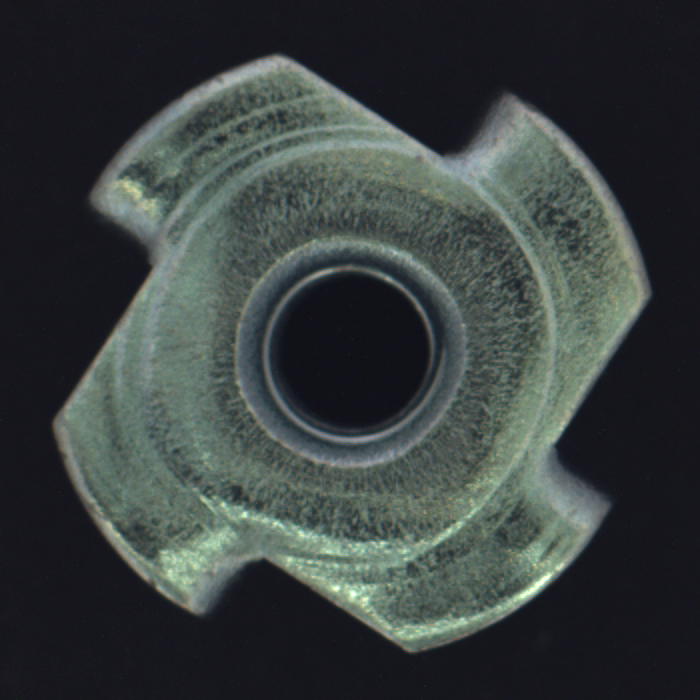

In [11]:
images_train = get_dataset_dict(config["dataset"], "train")
images_test = get_dataset_dict(config["dataset"], "test")
masks_test = get_dataset_dict(config["dataset"], "ground_truth")

Image.open(images_train["good/000"]) # example

# Datamodule

In [12]:
def get_category(key: str) -> str:
    """Example: 'scratch/000' -> 'scratch'"""
    return key.split("/")[0]


def get_label(key: str) -> str:
    """Example: 'scratch/000' -> 'anomaly'"""
    return "normal" if get_category(key) == "good" else "anomaly"


def get_label_index(key: str) -> int:
    """Example: 'scratch/000' -> 1'"""
    return 0 if get_label(key) == "normal" else 1

In [13]:
def get_datamodule(images_train: Dict, images_test: Dict, masks_test: Dict, params_dataset: Dict, params_augmentation: Dict) -> LightningDataModule:
    masks_test = {key[:-5]: val for key, val in masks_test.items()}
    augmentation = A.Compose([
        A.MedianBlur(**params_augmentation["MedianBlur"]),
        A.RandomBrightnessContrast(**params_augmentation["RandomBrightnessContrast"])
    ])
    datamodule = CustomDataModule(
        images_train,
        images_test,
        masks_test,
        test_size=params_dataset["test_size"],
        image_size=params_dataset["image_size"],
        train_batch_size=params_dataset["train_batch_size"],
        test_batch_size=params_dataset["test_batch_size"],
        num_workers=params_dataset["num_workers"],
        transform_config_train=params_dataset["transform_config"]["train"],
        transform_config_val=params_dataset["transform_config"]["val"],
        seed=params_dataset["seed"],
        task=params_dataset["task"],
        train_transform=augmentation
    )
    datamodule.setup()
    return datamodule

In [14]:
class CustomDataset(Dataset):

    def __init__(self, images: Dict, pre_process, split: str, task: str, masks: Dict = None, transform: A.Compose = None) -> None:
        super().__init__()
        self.images = images
        self.keys = list(images.keys())
        self.pre_process = pre_process
        self.split = split
        self.task = task
        self.masks = masks
        self.transform = transform

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Dict:
        key = self.keys[idx]
        image = Image.open(self.images[key])
        image = np.array(image)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        pre_processed = self.pre_process(image=image)
        item = {"image": pre_processed["image"]}

        if self.split in ["val", "test"]:
            item["label"] = get_label_index(key)
            item["category"] = get_category(key)

            if self.task == "segmentation":
                if item["label"] == 0:
                    mask = np.zeros(shape=image.shape[:2])
                else:
                    mask = np.array(Image.open(self.masks[key])) / 255.

                pre_processed = self.pre_process(image=image, mask=mask)
                item["image"] = pre_processed["image"]
                item["mask"] = pre_processed["mask"]

        return item

In [15]:
class CustomDataModule(LightningDataModule):

    def __init__(
            self,
            images_train: Dict,
            images_test: Dict,
            masks_test: Dict = None,
            test_size: float = 0.5,
            image_size: Optional[Union[int, Tuple[int, int]]] = None,
            train_batch_size: int = 32,
            test_batch_size: int = 32,
            num_workers: int = 8,
            transform_config_train: Optional[Union[str, A.Compose]] = None,
            transform_config_val: Optional[Union[str, A.Compose]] = None,
            seed: Optional[int] = None,
            task: str = "classification",
            train_transform: Optional[A.Compose] = None
    ) -> None:
        """
        LightningDataModule handling data splitting, dataset and dataloader creation.

        Args:
            images_train: normal image for train
            images_test: normal and anomalous images for val and tests
            masks_test: ground truth segmentation masks for images_test
            test_size: the share of images_test going into the test set
            image_size: -
            train_batch_size:
            test_batch_size: batch size for validation and testing
            num_workers: num_workers for train, val and test dataloaders
            transform_config_train: transforms applied to train (without resizing and ToTensor)
                if None, normalization with ImageNet statistics is performed
            transform_config_val: transforms applied to val and test (without resizing and ToTensor)
                if None, normalization with ImageNet statistics is performed
            seed: seed used for the val-test split
            task: one of {"classification", "segmentation"}
            train_transform: albumentations compose to be applied to the train set
        """

        super().__init__()

        self.images_train = images_train
        self.images_test = images_test
        self.masks_test = masks_test
        self.test_size = test_size

        self.transform_config_train = transform_config_train
        self.transform_config_val = transform_config_val
        self.image_size = image_size

        if transform_config_train is not None and transform_config_val is None:
            self.transform_config_val = transform_config_train

        self.pre_process_train = PreProcessor(config=self.transform_config_train, image_size=image_size, to_tensor=True)
        self.pre_process_val = PreProcessor(config=self.transform_config_val, image_size=image_size, to_tensor=True)
        self.train_transform = train_transform

        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers
        self.seed = seed

        self.train_data = None
        self.val_data = None
        self.test_data = None

        self.task = task

    def setup(self, stage: Optional[str] = None) -> None:
        """
        Splits the test_images into a val and a test set and creates train, val and test datasets.
        The split is stratified by defect category.

        Args:
            stage: unused (sometimes set to "fit" or "predict" to only create certain datasets)
        """

        test_keys = list(self.images_test.keys())
        val_keys, test_keys = train_test_split(
            test_keys,
            test_size=self.test_size,
            random_state=self.seed,
            stratify=[get_category(key) for key in test_keys]
        )
        images_val = {key: value for key, value in self.images_test.items() if key in val_keys}
        images_test = {key: value for key, value in self.images_test.items() if key in test_keys}
        masks_val = {key: value for key, value in self.masks_test.items() if key in val_keys}
        masks_test = {key: value for key, value in self.masks_test.items() if key in test_keys}

        self.train_data = CustomDataset(
            images=self.images_train,
            pre_process=self.pre_process_train,
            split="train",
            task=self.task,
            transform=self.train_transform
        )

        self.val_data = CustomDataset(
            images=images_val,
            pre_process=self.pre_process_val,
            split="val",
            task=self.task,
            masks=masks_val
        )

        self.test_data = CustomDataset(
            images=images_test,
            pre_process=self.pre_process_val,
            split="test",
            task=self.task,
            masks=masks_test
        )

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_data,
            shuffle=True,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_data,
            shuffle=False,
            batch_size=self.test_batch_size,
            num_workers=self.num_workers
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_data,
            shuffle=False,
            batch_size=self.test_batch_size,
            num_workers=self.num_workers
        )

# Training & Validation

In [16]:
class Patchcore(Patchcore):
    def validation_step(self, batch, dataloader_idx=0):
        """Overwrites the validation_step in Dfm to not keep all images in memory."""
        batch = super().validation_step(batch)
        return {key: value for key, value in batch.items() if key != "image"}

In [17]:
def get_model(params_model: Dict) -> LightningModule:
    model = Patchcore(
        input_size=(params_model["input_size"], params_model["input_size"]),
        backbone=params_model["backbone"],
        layers=params_model["layers"],
        pre_trained=params_model["pre_trained"],
        coreset_sampling_ratio=params_model["coreset_sampling_ratio"],
        num_neighbors=params_model["num_neighbors"]
    )
    return model

In [18]:
def get_callbacks(params_metrics: Dict) -> list:
    callbacks = [
        PostProcessingConfigurationCallback(
            threshold_method=params_metrics["threshold"]["method"],
            manual_image_threshold=None,
            manual_pixel_threshold=None
        ),
        MetricsConfigurationCallback(
            task=params_metrics["task"],
            image_metrics=params_metrics.get("image", None),
            pixel_metrics=params_metrics.get("pixel", None)
        )
    ]
    return callbacks

In [19]:
def train(datamodule: LightningDataModule,
          params_model: Dict,
          params_metrics: Dict,
          params_trainer: Dict) -> Tuple[Trainer, LightningModule]:
    model = get_model(params_model)
    callbacks = get_callbacks(params_metrics)
    trainer = Trainer(**params_trainer, callbacks=callbacks)
    trainer.fit(model=model, datamodule=datamodule)
    return trainer, model

In [20]:
def validate(trainer: Trainer,
             model: LightningModule,
             datamodule: LightningDataModule) -> Tuple[pd.DataFrame, Figure, Figure, Figure]:
    """
    Predicts the val dataset and collects results (including diagnostic plots).

    Args:
        trainer: trainer from train
        model: model from train
        datamodule: datamodule form .data.get_datamodule

    Returns:
        df: information and results for each val sample
        roc_plot: roc-curve
        pr_plot: precision-recall curve
        score_plot: histogram of anomaly scores by category
    """
    results = trainer.predict(model=model, dataloaders=datamodule.val_dataloader())
    df = pd.DataFrame({
        "key": datamodule.val_data.keys,
        "label": torch.cat([d["label"] for d in results]).int().numpy(),
        "score": torch.cat([d["pred_scores"] for d in results]).float().numpy(),
        "pred": torch.cat([d["pred_labels"] for d in results]).int().numpy(),
        "category": np.concatenate([d["category"] for d in results])
    })

    ### ROC METRICS ###
    roc_auc = roc_auc_score(df["label"], df["score"])
    wandb.log({"roc_auc": roc_auc})

    fpr, tpr, thresholds = roc_curve(df["label"], df["score"])
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot().figure_

    ### PRECISION RECALL METRICS ###
    ap = average_precision_score(df["label"], df["score"])
    wandb.log({"AP": ap})
    
    precision, recall, _ = precision_recall_curve(df["label"], df["score"])
    pr_plot = PrecisionRecallDisplay(precision=precision, recall=recall).plot().figure_

    f1 = f1_score(df["label"], df["pred"])
    wandb.log({"f1": f1})

    ### ACCURACY ###
    df["correct"] = df["label"] == df["pred"]
    accuracy_by_category = df.groupby("category")["correct"].mean()
    for cat, acc in accuracy_by_category.iteritems():
        wandb.log({f"accuracy-{cat}": acc})

    ### ANOMALY SCORE ###
    score_plot = plt.figure()
    sns.boxplot(data=df, x="category", y="score", orient="v")
    plt.close()

    return df, roc_plot, pr_plot, score_plot

In [21]:
def get_threshold(df: pd.DataFrame, model, threshold_params: Dict) -> LightningModule:
    normal_scores = df[df["label"] == 0]["score"]
    image_threshold = normal_scores.quantile(threshold_params["quantile"])
    model.threshold_method = ThresholdMethod.MANUAL
    model.image_threshold.value = torch.tensor(image_threshold).cpu()
    return model

# Inference

In [22]:
def get_inference_dataloader(file: str, params_dataset: Dict) -> DataLoader:
    """
    Creates an inference dataloader for a single image to be provided to the trainer for prediction.

    Args:
        image: path to the inference image
        params_dataset: the keys transform_config.val and image_size are needed

    Returns:
        dataloader: dataloader to be provided to the trainer
    """
    image = {"image": file}
    pre_process = PreProcessor(
        config=params_dataset["transform_config"]["val"],
        image_size=params_dataset["image_size"],
        to_tensor=True
    )
    dataset = CustomDataset(image, pre_process, split="prediction", task=params_dataset["task"])
    dataloader = DataLoader(dataset)
    return dataloader

In [23]:
def get_prediction(model: LightningModule, inference_dataloader: DataLoader, params_trainer: Dict) -> str:
    """
    Args:
        model: -
        inference_dataloader: inference dataloader created by .data.get_inference_dataloader
        params_trainer: parameters for the Trainer constructor

    Returns:
        prediction: one of {"anomaly", "normal"}
    """
    trainer = Trainer(**params_trainer)
    results = trainer.predict(model=model, dataloaders=inference_dataloader)
    prediction = "anomaly" if results[0]["pred_labels"] else "normal"
    return results, prediction

# Putting Everything Together

In [24]:
seed_everything(config["seed"], workers=True)
datamodule = get_datamodule(images_train, images_test, masks_test, config["params_dataset"], config["params_augmentation"])
trainer, model = train(datamodule, config["params_model"], config["params_metrics"], config["params_trainer"])
results_df, roc_plot, pr_plot, score_plot = validate(trainer, model, datamodule)
model = get_threshold(results_df, model, config["params_threshold"])

wandb.log({
    "results_df": results_df,
    "roc_plot": roc_plot,
    "pr_plot": pr_plot,
    "score_plot": score_plot   
})

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/wide_resnet50_racm-8234f177.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_racm-8234f177.pth
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packag

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 7it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Predicting: 0it [00:00, ?it/s]

Prediction: anomaly


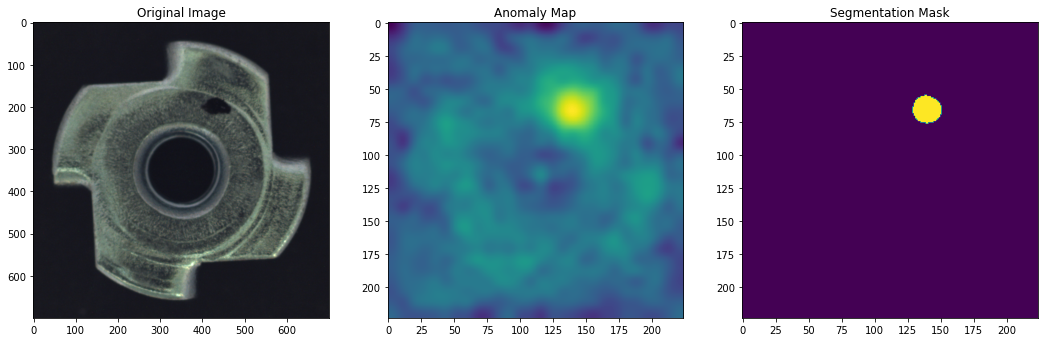

In [25]:
inference_image = "/kaggle/input/mvtec-ad/metal_nut/test/color/000.png" 
inference_dataloader = get_inference_dataloader(inference_image, config["params_dataset"])
results, prediction = get_prediction(model, inference_dataloader, config["params_trainer"])

print("\033[1m" + "Prediction: " + prediction + "\033[0;0m")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(np.array(Image.open(inference_image)))

plt.subplot(1, 3, 2)
plt.title("Anomaly Map")
plt.imshow(results[0]["anomaly_maps"].squeeze())

plt.subplot(1, 3, 3)
plt.title("Segmentation Mask")
plt.imshow(results[0]["pred_masks"].squeeze());

# Error Analysis

In [26]:
results_df.head()

key  label      score  pred category  correct
0  good/007      0  40.180950     1     good    False
1  good/011      0  36.796719     0     good     True
2  good/017      0  36.758564     0     good     True
3  good/002      0  35.632435     0     good     True
4  good/003      0  35.057961     0     good     True

## Difficult Good Images


key  label      score  pred category  correct
0  good/007      0  40.180950     1     good    False
9  good/008      0  39.507412     1     good    False
7  good/010      0  37.578888     0     good     True
1  good/011      0  36.796719     0     good     True
2  good/017      0  36.758564     0     good     True

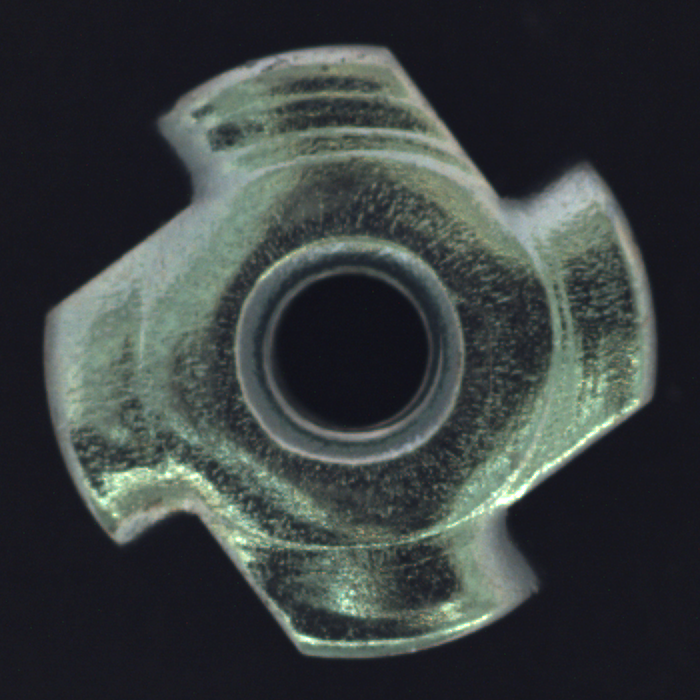

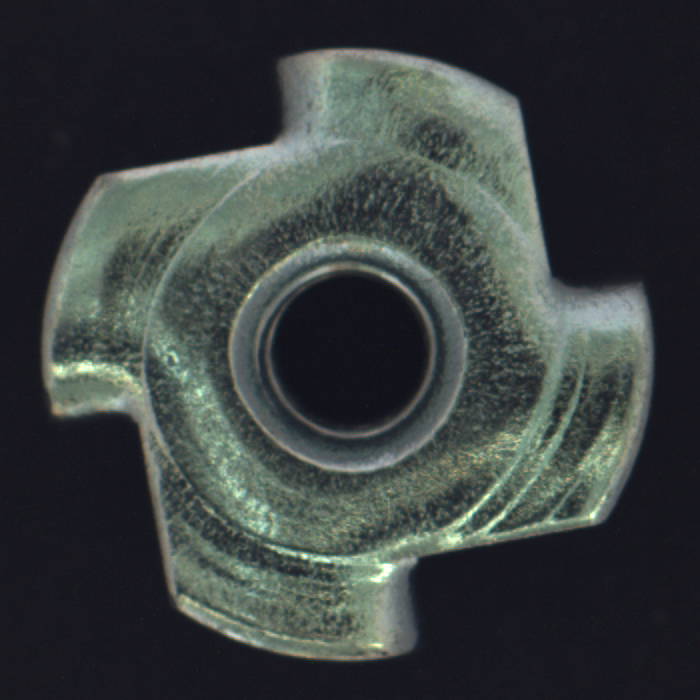

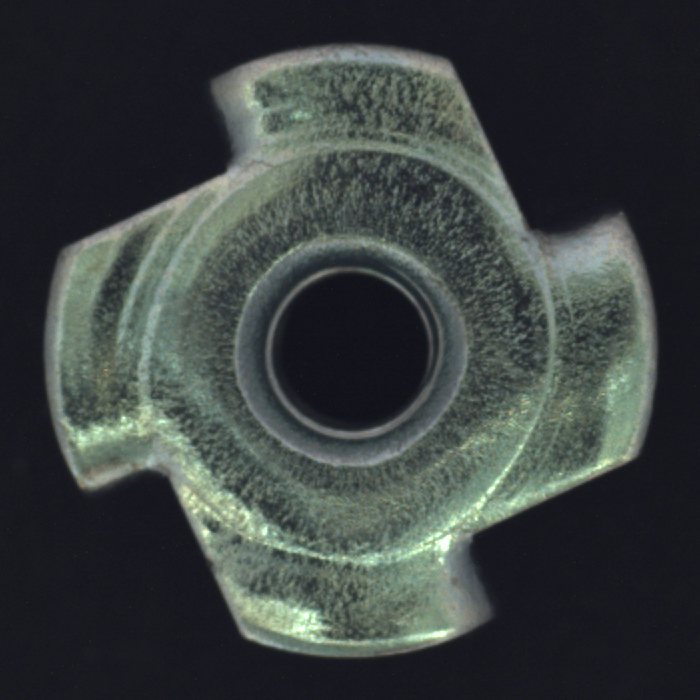

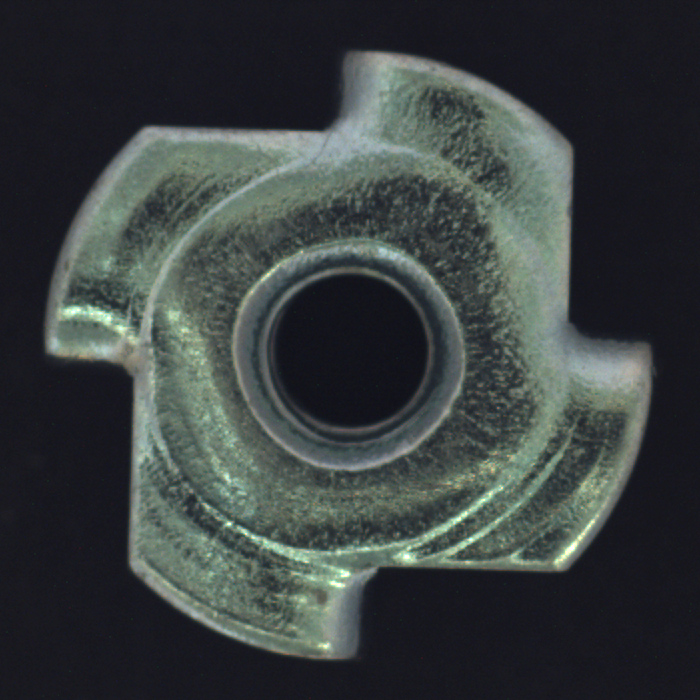

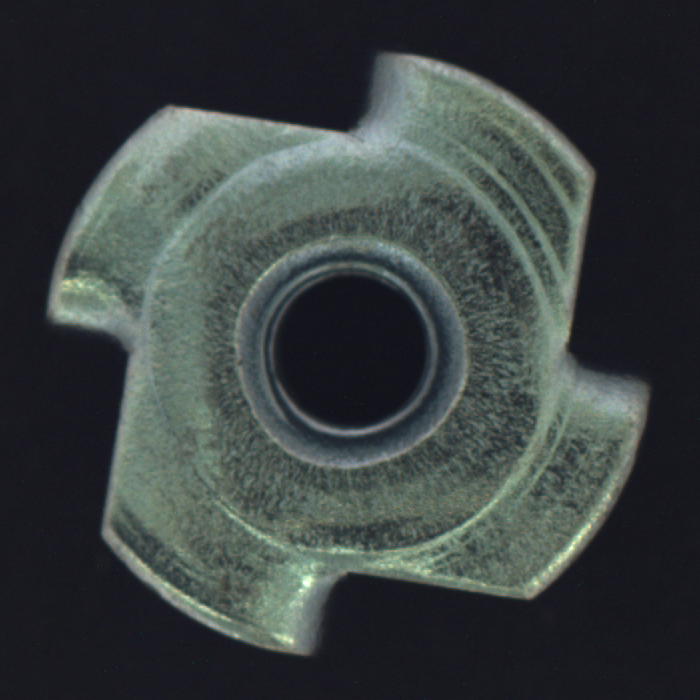

In [27]:
good_images = results_df[results_df["category"] == "good"]
good_images_sorted = good_images.sort_values("score", ascending=False)

display(good_images_sorted.head())

for key in good_images_sorted["key"][:5]:
    display(Image.open(images_test[key]))

## Difficult Anomalous Images

key  label      score  pred category  correct
48    color/004      1  37.615753     1    color     True
49    color/018      1  39.644505     1    color     True
11     bent/007      1  41.409412     1     bent     True
51    color/019      1  42.341846     1    color     True
39  scratch/022      1  42.936184     1  scratch     True

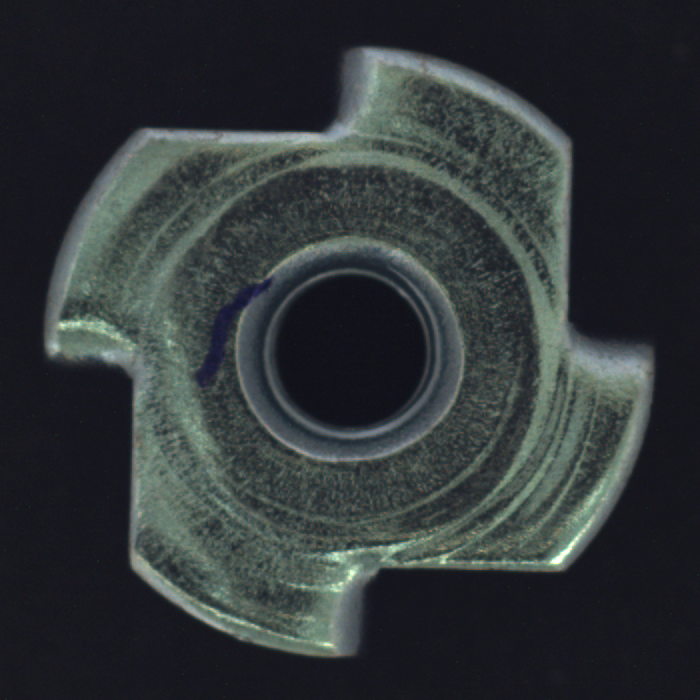

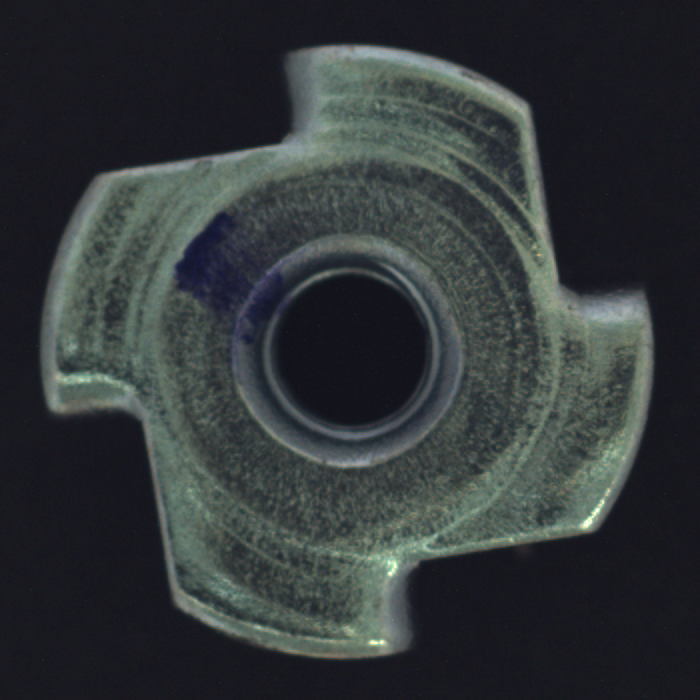

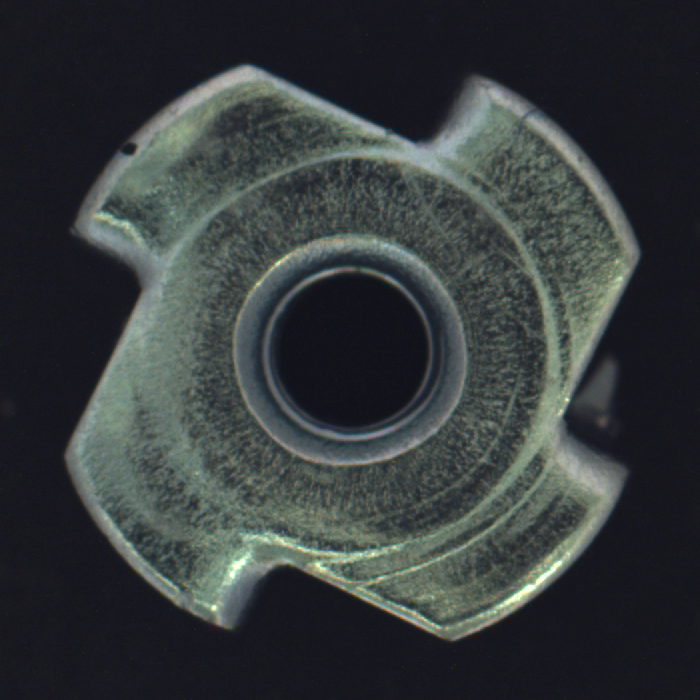

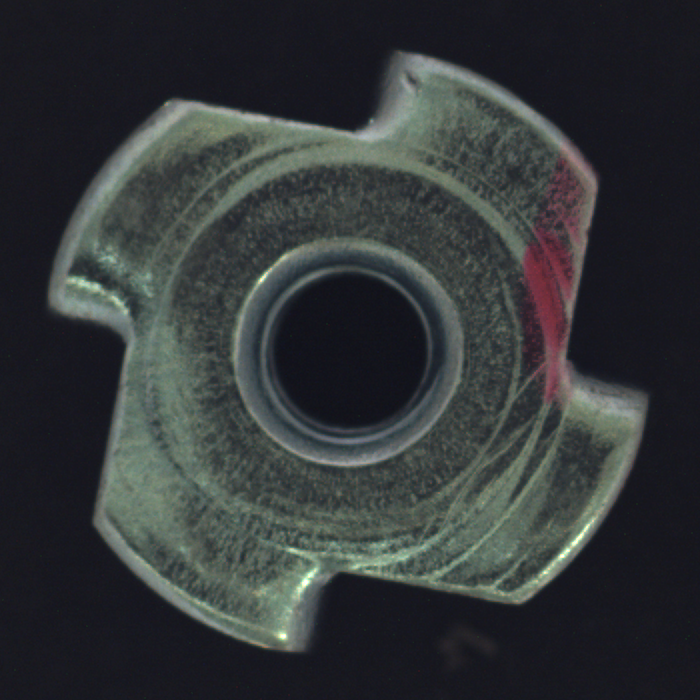

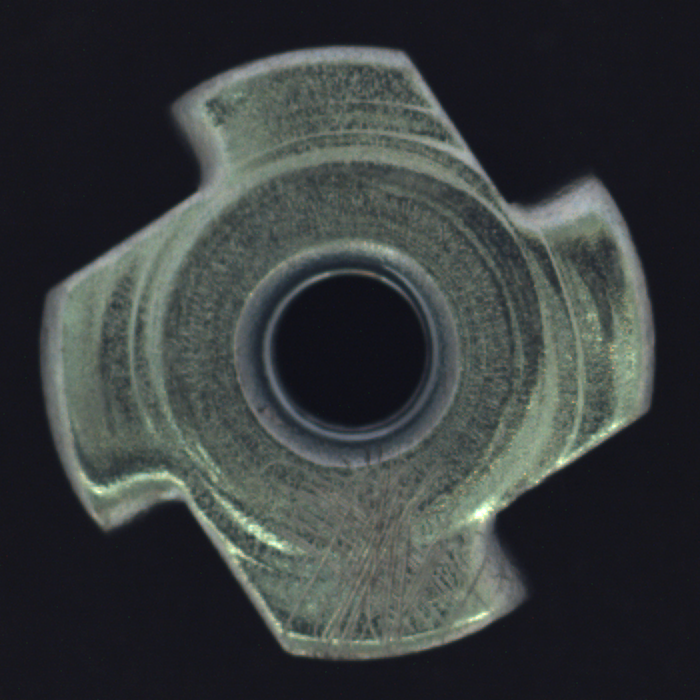

In [28]:
anomalous_images = results_df[results_df["category"] != "good"]
anomalous_images_sorted = anomalous_images.sort_values("score", ascending=True)

display(anomalous_images_sorted.head())

for key in anomalous_images_sorted["key"][:5]:
    display(Image.open(images_test[key]))

In [29]:
wandb.finish()